<a href="https://colab.research.google.com/github/austin-leung/whos-that-pokemon/blob/master/pokemonCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Who's That Pokémon?

A convolutional neural network trained to identify Pokémon. Currently a work in progress!

![alt text](https://i.ytimg.com/vi/09saU1wbuBo/maxresdefault.jpg)

---

### Integrating Google Colab with Google Drive

I decided to use Google Colab for this project as it gives me access to GPU power to run my machine learning model. I learned how to download datasets into Google Colab from the following article: https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166. 

Here, I mount the drive to Google Colab and then upload the files and upload the kaggle.json file connecting to my kaggle account's API key. This allows me to access files in my drive from this Jupyter Notebook file. 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
from google.colab import files
files.upload()

### Download Images from Kaggle


I found a wonderful dataset of handpicked images of the over 928 currently released Pokémon (with their various forms) uploaded onto Kaggle (https://www.kaggle.com/mrgravelord/complete-pokemon-image-dataset). There are 15-50 images of each Pokémon. It is a very small dataset to train a neural network with, but we do our best with what we've got.

I create the folder path for the kaggle.json file.

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

The dataset of images is downloaded to my Google Drive directory in a folder called pkmnDataset and then unzipped.

In [0]:
!kaggle datasets download -d mrgravelord/complete-pokemon-image-dataset -p /content/drive/My\ Drive/pkmnDataset

In [0]:
import os
!unzip -q /content/drive/My\ Drive/pkmnDataset/complete-pokemon-image-dataset.zip -d /content/drive/My\ Drive/pkmnImgs

First, I check if I can train my network on GPU as it is much faster than CPU generally. Google Colab ensures I have the GPU to use.

In [161]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Load Training and Testing Data

Much of the following code is graciously borrowed from Udacity's Intro to Deep Learning course! Check it out here https://www.udacity.com/course/deep-learning-pytorch--ud188. 

Now using PyTorch, I download the training data, resizing the 160x160 images to 32x32 to reduce the complexity of the model. Then i normalize the tensors, allowing for 3 dimensions for width, height, and RGB color.

75% of the images are used for training, 15% for validation, and 15% for testing. This helps to prevent overfitting. Later on, while I'm training the data, I will test my model on the validation dataset to decide when to stop training. The testing dataset will of course be used to evaluate the accuracy of my model.

In [548]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as testing and validation
test_size = 0.15

# convert data to a normalized torch.FloatTensor
trainTransform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # third dim for RGB
    ])

# Download and load the data
imgData = datasets.ImageFolder('/content/drive/My Drive/pkmnImgsSubset', 
                               transform=trainTransform)

# obtain training indices that will be used for training and testing datasets
num_train = len(imgData)
indices = list(range(num_train))
np.random.shuffle(indices)
splitTest = int(np.floor(test_size * 2 * num_train))
train_idx, test_idx = indices[splitTest:], indices[:splitTest]

# validation dataset will be the same percentage as testing dataset
num_test = len(test_idx)
splitValid = int(np.floor(0.5 * num_test))
valid_idx, test_idx = test_idx[splitValid:], test_idx[:splitValid]

# Verify the number of image indices going to each dataset is 70%, 15%, 15%
print("train:", len(train_idx),
      "valid:", len(valid_idx), 
      "test:", len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# We take 35 images per batch 
train_loader = torch.utils.data.DataLoader(imgData, batch_size=batch_size, 
                                          sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(imgData, batch_size=batch_size, 
                                           sampler=test_sampler)
valid_loader = torch.utils.data.DataLoader(imgData, batch_size=batch_size, 
                                           sampler=valid_sampler)

train: 189 valid: 41 test: 40


### Visualize an Image

Before I define and run my model, I create a class list of all the Pokémon. I can use the class list to label Pokémon images based on the directory the image came from. I also view an image I have downloaded to make sure everything is as I expect, such as size and Pokémon labels.

In addition, I view an image in terms of its normalized pixel values. There is a red, green, and blue channel, showing the three dimensional nature at the convolutional layer. Each channel highlights different features of the image.

Image tensor shape: (35, 3, 32, 32)


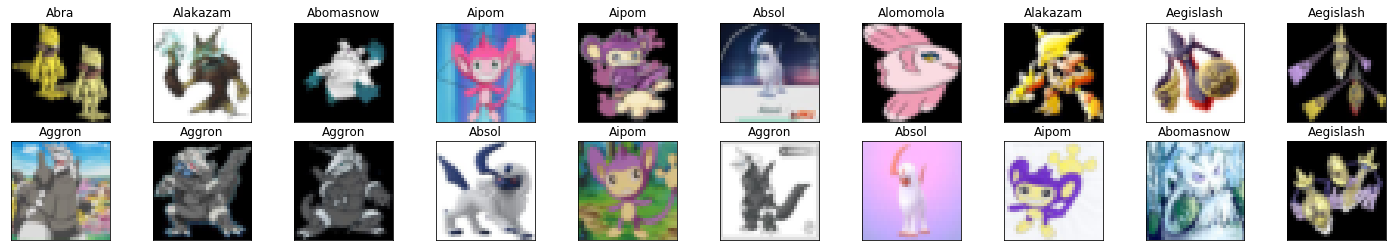

In [528]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print("Image tensor shape:", images.shape)

# create a list of classes after mapping labels to pokemon
pkmnIndDict = imgData.class_to_idx
classes = list(pkmnIndDict.keys())

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

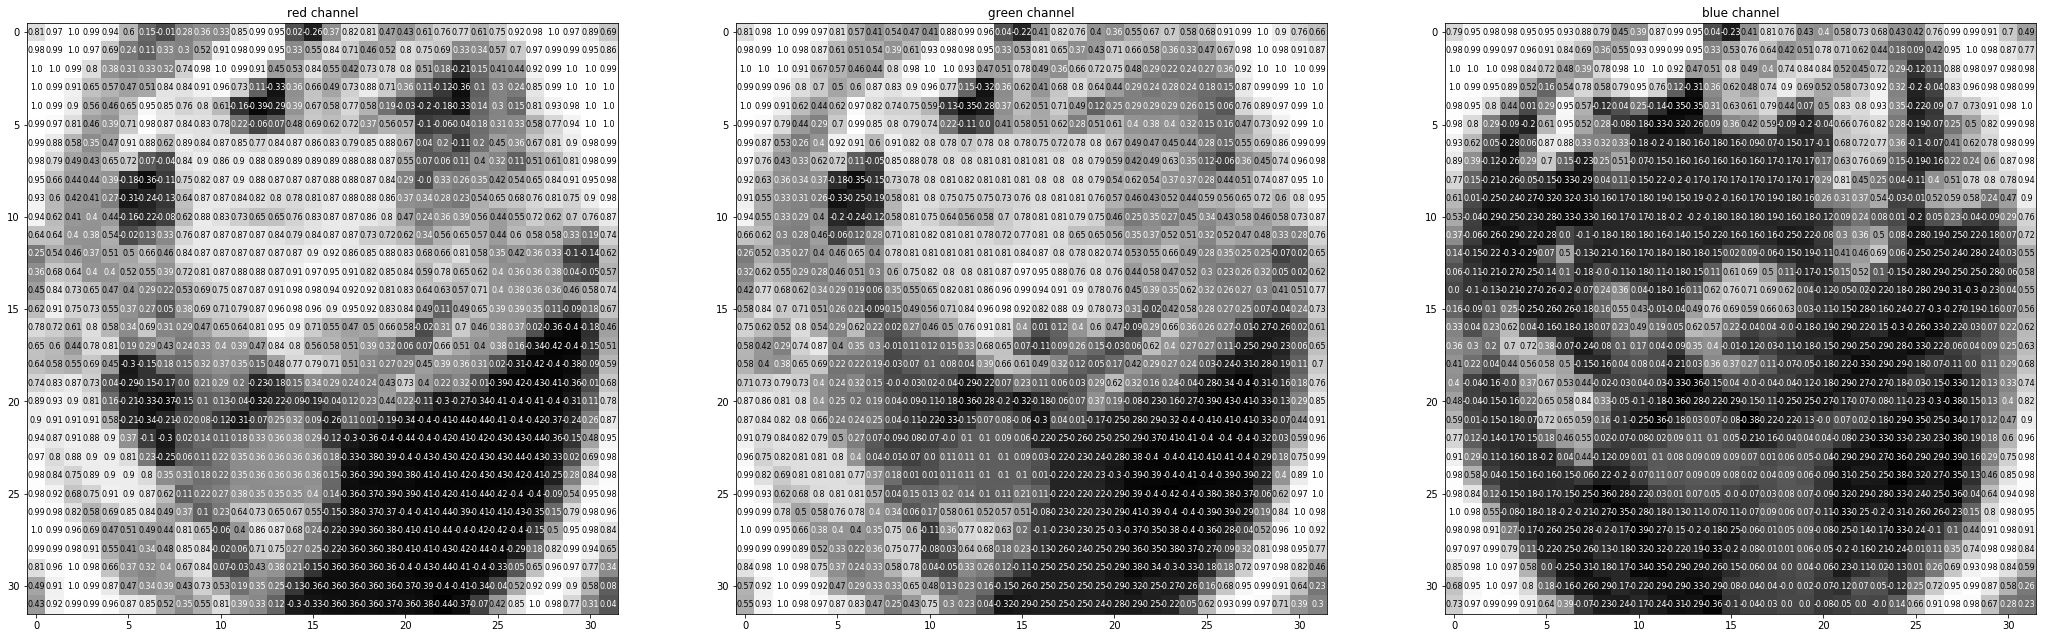

In [504]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

### Define the Model

I finally define my sequential model here. 

I choose a stride 3 for my convolutional filter and thus apply a zero padding of size 1 to my convolutional layers so that the filter will work around the edges.

In my forward function, a pooling layer is applied after every convolution layer and activation function. I use a hard-tanh activation function as I found the best results with it (having tried others like ReLu and sigmoid).

The image reduces in size each time, having its width and height divided by 2. The last convolutional layer has a depth of 64 and an x, y size of 4x4. It is flattened into a one row tensor of size 64 * 4 * 4. I add a dropout layer to help prevent overfitting before each fully connected layer. Then, the 64 * 4 * 4 inputs are passed into the first fully connected layer.

The next and last fully connected layer takes the 500 outputs of the first and produces 10 class scores for 10 different Pokémon.

In [565]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layer
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.hardtanh(self.conv1(x)))
        x = self.pool(F.hardtanh(self.conv2(x)))
        x = self.pool(F.hardtanh(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with hard-tanh activation function
        x = F.hardtanh(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with hard-tanh activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

import torch.optim as optim

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


### Train the Model

Before I train the model, I specify my loss function as categorical cross-entropy and optimizer as stochastic gradient descent with a learning rate of 0.1.

I run a maximum of 1000 epochs although it will likely not be reached as I stop training the model if the validation loss does not decrease for 10 epochs. The model is trained exclusively with the training data but is checked every epoch against the validation data to find a good stop point, preventing overfitting.

Training is done through a forward pass predicting outputs followed by calculating the loss, backpropagation, and an optimizer step.

In [569]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# number of epochs to train the model
n_epochs = 1000

valid_loss_min = np.Inf # track change in validation loss

noValidChangeCount = 0 # stop if validation loss hasn't decreased in 10 epochs

lastValidPrinted = True

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backpropagation: compute loss gradientwith respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    if epoch % 5 == 0:
      # format printing new line
      if not lastValidPrinted: print()
      print('''Epoch: {} \tTraining Loss: {:.4f} \t
                Validation Loss: {:.4f}'''.format(
            epoch, train_loss, valid_loss), end="")
      if valid_loss <= valid_loss_min: lastValidPrinted = True
      else: lastValidPrinted = False
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        if epoch % 5 == 0:
          print(' ({:.4f} --> {:.4f})'.format(
                valid_loss_min,
                valid_loss))
        torch.save(model.state_dict(), 'model_pokemon.pt')
        valid_loss_min = valid_loss
        noValidChangeCount = 0
    
    noValidChangeCount += 1
    if noValidChangeCount == 10: 
      print("\nDone! Final Validation Loss:", valid_loss_min)
      break

    

Epoch: 5 	Training Loss: 0.5703 	
                Validation Loss: 1.4142
Epoch: 10 	Training Loss: 0.2036 	
                Validation Loss: 2.6366
Done! Final Validation Loss: 1.208626793652046


In [571]:
model.load_state_dict(torch.load('model_pokemon.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [572]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.213673

Test Accuracy of Abomasnow: 100% ( 3/ 3)
Test Accuracy of  Abra: N/A (no training examples)
Test Accuracy of Absol: 100% ( 2/ 2)
Test Accuracy of Accelgor: 100% ( 1/ 1)
Test Accuracy of Aegislash: 50% ( 1/ 2)
Test Accuracy of Aerodactyl:  0% ( 0/ 2)
Test Accuracy of Aggron: 66% ( 4/ 6)
Test Accuracy of Aipom: 30% ( 3/10)
Test Accuracy of Alakazam: 55% ( 5/ 9)
Test Accuracy of Alomomola: 60% ( 3/ 5)

Test Accuracy (Overall): 55% (22/40)


Prediction (Actual)


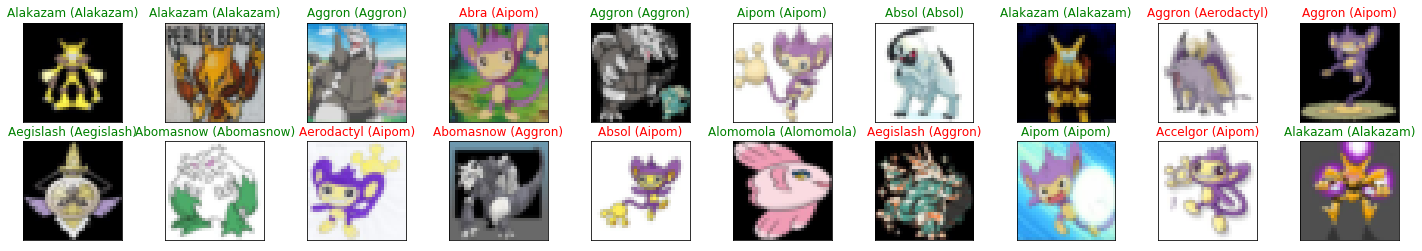

In [579]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
print("Prediction (Actual)")
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))